In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For plotting graphs
import matplotlib.pyplot as plt

# For Exploratory Data Analysis (EDA)
import seaborn as sns

# For text cleaning
import re

# For natural language processing
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from collections import Counter

# For learning setup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# For Tensorflow related dependencies
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Error management
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-football/real.csv
/kaggle/input/fake-news-football/fake.csv


In [2]:
real = pd.read_csv("/kaggle/input/fake-news-football/real.csv")
false = pd.read_csv("/kaggle/input/fake-news-football/fake.csv")

# **Reading the head of the real news dataset**

In [3]:
real.head()

,tweet
0,sun downs technical director: al-ahly respecte...
1,shawky gharib after the tie with enppi: our go...
2,"egyptian sports news today, wednesday 1/25/202..."
3,the main referees committee of the egyptian fo...
4,"haji bari, the striker of the future team, is ..."


In [4]:
print("The number of duplicate data in the real dataset is: ", real.duplicated().sum())
print("The number of duplicate data in the false dataset is: ", false.duplicated().sum())

The number of duplicate data in the real dataset is:  624
The number of duplicate data in the false dataset is:  418


We then go ahead to join the false and real news datasets, in order to facilitate better understanding as we analyse

In [5]:
# Now we get rid of the duplicated data in order to get an accurate reading
real = real.drop_duplicates()
false = false.drop_duplicates()

In [6]:
real["label"]=1
false["label"]=0

In [7]:
real.head()

,tweet,label
0,sun downs technical director: al-ahly respecte...,1
1,shawky gharib after the tie with enppi: our go...,1
2,"egyptian sports news today, wednesday 1/25/202...",1
3,the main referees committee of the egyptian fo...,1
4,"haji bari, the striker of the future team, is ...",1


In [8]:
false.head()

,tweet,label
0,"the tongue of his condition, now i saw things ...",0
1,"by god the great, after i saw the derby of wyd...",0
2,"believe in god, this zamalek fans are as good ...",0
3,the coach appeared in the media and told the t...,0
4,asno smito\nwhoever knows her tells me a massa...,0


In [9]:
data=pd.concat([false,real],axis=0)

In [10]:
data.head()

,tweet,label
0,"the tongue of his condition, now i saw things ...",0
1,"by god the great, after i saw the derby of wyd...",0
2,"believe in god, this zamalek fans are as good ...",0
3,the coach appeared in the media and told the t...,0
4,asno smito\nwhoever knows her tells me a massa...,0


In [11]:
data.columns=["text","label"]

In [12]:
data.head()

,text,label
0,"the tongue of his condition, now i saw things ...",0
1,"by god the great, after i saw the derby of wyd...",0
2,"believe in god, this zamalek fans are as good ...",0
3,the coach appeared in the media and told the t...,0
4,asno smito\nwhoever knows her tells me a massa...,0


In [13]:
data['label'].value_counts()

label
1    21245
0    19581
Name: count, dtype: int64

In [14]:
data["text"]=data['text'].astype(str)

In [15]:
data.head()

,text,label
0,"the tongue of his condition, now i saw things ...",0
1,"by god the great, after i saw the derby of wyd...",0
2,"believe in god, this zamalek fans are as good ...",0
3,the coach appeared in the media and told the t...,0
4,asno smito\nwhoever knows her tells me a massa...,0


In [16]:
#converting into the lowercase
def lowercase(text):
    text=text.lower()
    return text

data['text']=data['text'].apply(lowercase)

In [17]:
# cleaning the text data 

def text_clean(text):  
    text=re.sub("\[.*#&]"," ",text)
    text=re.sub("https?://\S+|www\.\S+","",text)
    text=re.sub("[^a-zA-Z0-9\s]+","",text)
    text = re.sub('\w*\d\w*', '', text)
    stop_words = set(stopwords.words('english'))
    words = text.split()
    
    
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

   
    return text
    
data["text"]=data["text"].apply(text_clean)

In [18]:
data.head()

,text,label
0,tongue condition saw things confused shame you...,0
1,god great saw derby wydad alraja almaghribi be...,0
2,believe god zamalek fans good swear god celebr...,0
3,coach appeared media told truth got told swear...,0
4,asno smito whoever knows tells massage whoever...,0


In [19]:
# Now we import NLTK for Natural Language Processing

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
from nltk.stem import SnowballStemmer

# initialize SnowballStemmer 
stemmer = SnowballStemmer('english')

def stem_text(text):
    # Tokenize the input text into individual words
    tokens = nltk.word_tokenize(text)
    
    # Stem each token using the SnowballStemmer
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join the stemmed tokens back into a single string
    return ' '.join(stemmed_tokens)

In [22]:
# apply stemming to the 'text' column in your DataFrame
data['text'] = data['text'].apply(stem_text)
# Show the updated dataframe
data.head()

,text,label
0,tongu condit saw thing confus shame young haha...,0
1,god great saw derbi wydad alraja almaghribi be...,0
2,believ god zamalek fan good swear god celebr u...,0
3,coach appear media told truth got told swear r...,0
4,asno smito whoever know tell massag whoever do...,0


# **Exploratory Data Analysis (EDA) with Seaborn and Matplotlib**

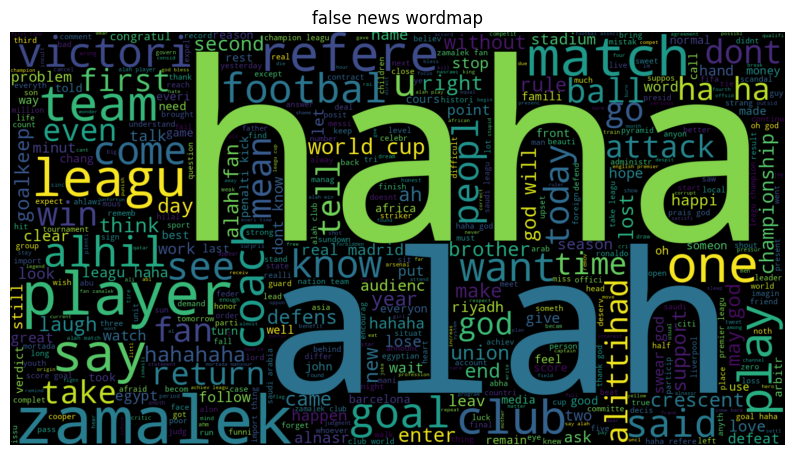

In [23]:
def wordcloud_text(text):
    
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('false news wordmap')
    plt.show()
    
false_text = " ".join(data[data['label'] == 0]['text'])  #here 0 for false news
wordcloud_text(false_text) #for positive sentence

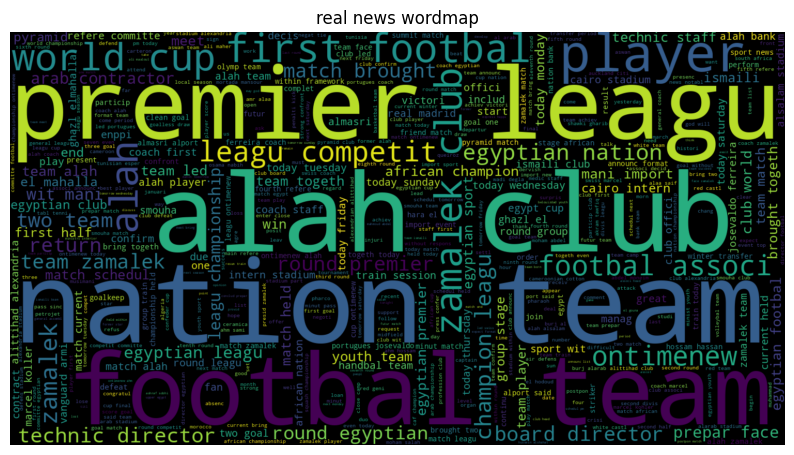

In [24]:
def wordcloud_text(text):
    
    plt.figure(figsize = (10, 8))
    wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('real news wordmap')
    plt.show()
    
real_text = " ".join(data[data['label'] == 1]['text'])  #here 0 for real news
wordcloud_text(real_text) #for positive sentence

<Figure size 1000x500 with 0 Axes>

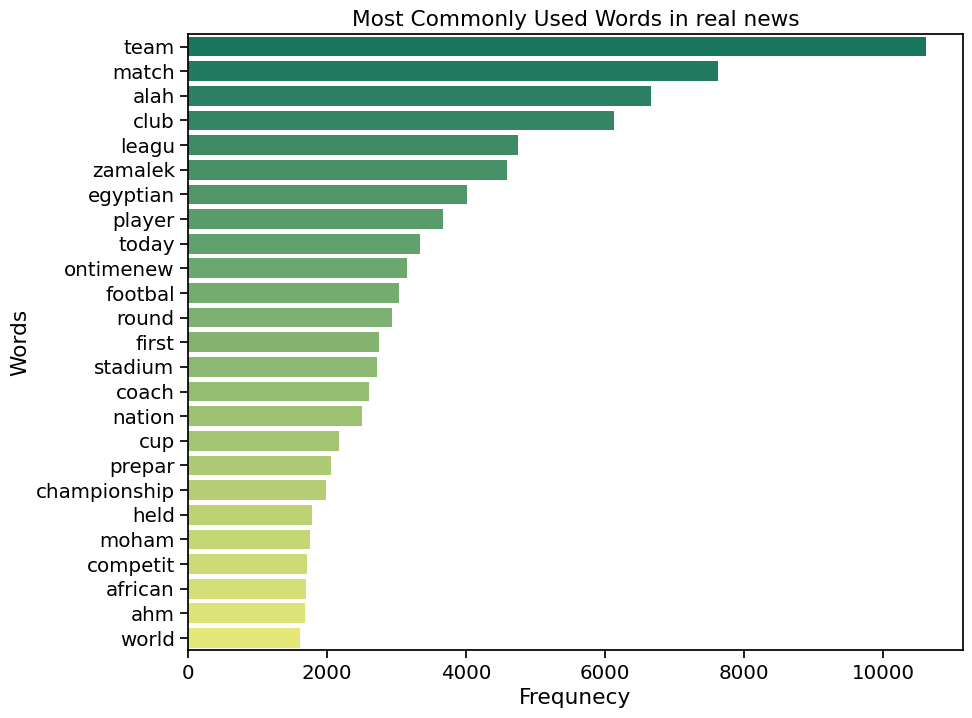

In [25]:
plt.figure(figsize=(10,5))
def plot_words_freq(words):
    
    
    #counter is predifined function which is used to count words
    df1 = pd.DataFrame(Counter(words).most_common(25), columns= ['Word', 'Frequency'])

    sns.set_context('notebook', font_scale= 1.3)
    plt.figure(figsize=(10,8))
    sns.barplot(y = df1['Word'], x= df1['Frequency'], palette= 'summer')
    plt.title("Most Commonly Used Words in real news")
    plt.xlabel("Frequnecy")
    plt.ylabel("Words") 
    return plt.show()


plot_words_freq((real_text).split())

<Figure size 1000x500 with 0 Axes>

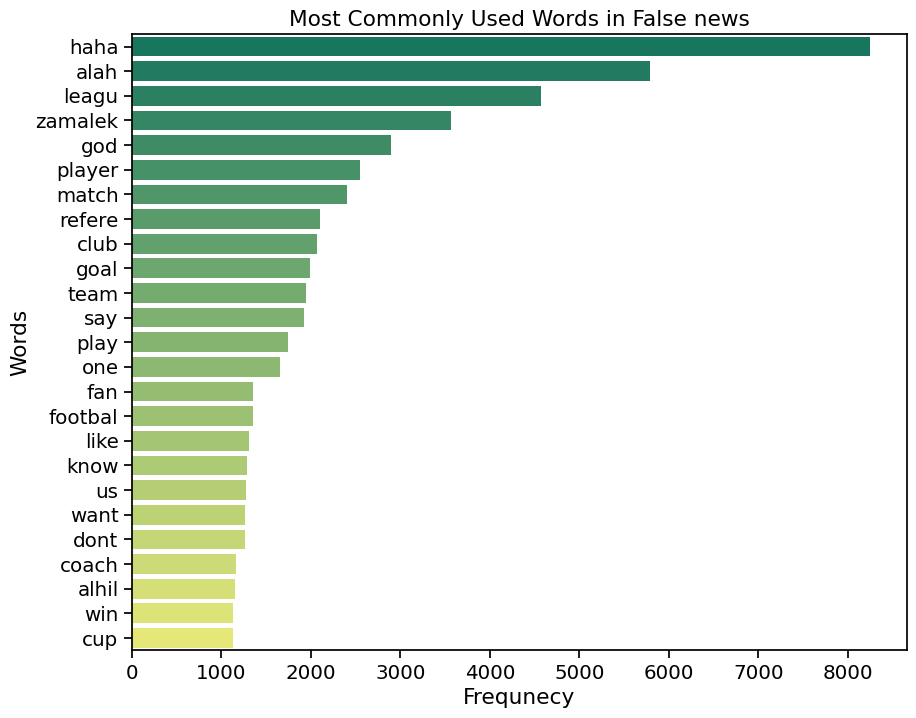

In [26]:
plt.figure(figsize=(10,5))
def plot_words_freq(words):
    
    df1 = pd.DataFrame(Counter(words).most_common(25), columns= ['Word', 'Frequency'])

    sns.set_context('notebook', font_scale= 1.3)
    plt.figure(figsize=(10,8))
    sns.barplot(y = df1['Word'], x= df1['Frequency'], palette= 'summer')
    plt.title("Most Commonly Used Words in False news")
    plt.xlabel("Frequnecy")
    plt.ylabel("Words") 
    return plt.show()


plot_words_freq((false_text).split())

# **Training the model**

In [27]:
# Define TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Vectorize the text data
X = vectorizer.fit_transform(data['text'])

# Define target variable
y = data['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB().fit(X_train, y_train)

nb_model.score(X_test,y_test)

0.9423218221895665

In [29]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier()

rfc.fit(X_train, y_train)

rfc.score(X_test,y_test)

0.9434239529757531

In [30]:
# Maximum number of words to be considered in the vocabulary
max_words = 10000 
# Maximum number of tokens in a sequence
max_len = 200 
# Tokenizer
tokenizer = Tokenizer(num_words = max_words) 
# Snap tokenizer to text data
tokenizer.fit_on_texts(data['text']) 
# Converts texts into strings of numbers
sequences_train = tokenizer.texts_to_sequences(data['text']) 
sequences_val = tokenizer.texts_to_sequences(data['text']) 
# Mapping words to indexes
word_index = tokenizer.word_index 

In [31]:
data_train = pad_sequences(sequences_train, maxlen = max_len)
data_val = pad_sequences(sequences_val, maxlen = max_len)

# **Recurrent Neural Network using TensorFlow**

In [32]:
# Create the model
model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length = max_len))
model.add(GlobalAveragePooling1D())

model.add(Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Checking summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
print(data_train.shape)
print(data.shape)

(40826, 200)
(40826, 2)


In [34]:
# Fit model
history = model.fit(data_train, data['label'], epochs = 10, batch_size = 64, validation_data = (data_val,data['label']))

Epoch 1/10
638/638 [==============================] - 5s 7ms/step - loss: 0.6509 - accuracy: 0.7131 - val_loss: 0.5758 - val_accuracy: 0.8969
Epoch 2/10
638/638 [==============================] - 4s 7ms/step - loss: 0.4822 - accuracy: 0.9079 - val_loss: 0.3982 - val_accuracy: 0.9043
Epoch 3/10
638/638 [==============================] - 6s 9ms/step - loss: 0.3439 - accuracy: 0.9132 - val_loss: 0.2985 - val_accuracy: 0.9173
Epoch 4/10
638/638 [==============================] - 6s 9ms/step - loss: 0.2702 - accuracy: 0.9220 - val_loss: 0.2446 - val_accuracy: 0.9249
Epoch 5/10
638/638 [==============================] - 5s 8ms/step - loss: 0.2276 - accuracy: 0.9286 - val_loss: 0.2113 - val_accuracy: 0.9301
Epoch 6/10
638/638 [==============================] - 6s 9ms/step - loss: 0.2000 - accuracy: 0.9333 - val_loss: 0.1880 - val_accuracy: 0.9378
Epoch 7/10
638/638 [==============================] - 6s 9ms/step - loss: 0.1800 - accuracy: 0.9382 - val_loss: 0.1712 - val_accuracy: 0.9427
Epoch 

In [35]:
loss, accuracy = model.evaluate(data_val, data['label'], verbose = 0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.804782


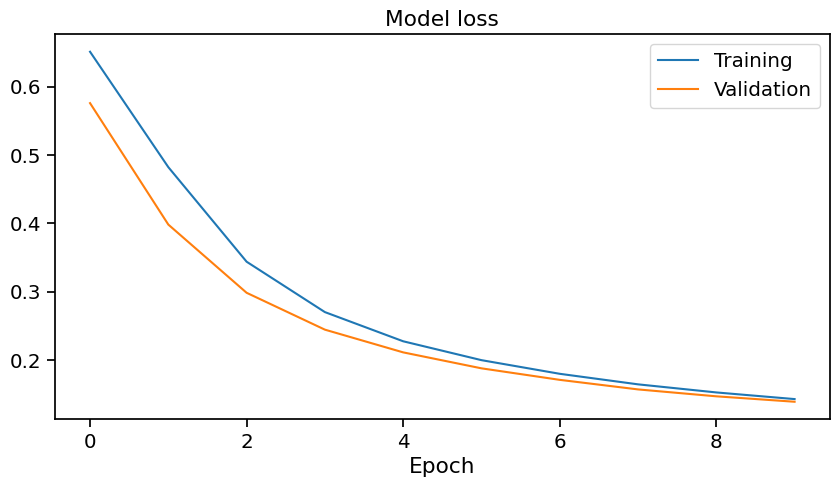

In [36]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc = 'upper right')
plt.show()